# Programming Assignment 1

In Part 2, you have to implement a logistic regression model and SVM model to predict the species of a pumpkin seeds using various morphological features.

You have to write your code in this jupyter notebook and submit the solved jupyter notebook with the file name \<Roll_No\>_A1_2.ipynb for evaluation. You have to enter your code only in those cells which are marked as ```## CODE REQUIRED ##```, and you have to write your code only between ```### START CODE HERE ###``` and ```### END CODE HERE ###``` comments.

## Part 2: Logistic Regression

### Problem Statement
Pumpkin seeds are frequently consumed as confection worldwide because of their adequate amount of protein, fat, carbohydrate, and mineral contents. There are two quality types of pumpkin seeds, ‘‘Urgup_Sivrisi’’ and ‘‘Cercevelik’’.Given various features of pumkin seeds such as area, perimeter, axis lengths etc. as input features, the task is to build a logistic regression model to predict the type of pumpkin seed.

### Dataset Description

Dataset Filename: Pumpkin_Dataset.csv

Attribute Information:

+ Area: Represents the number of pixels within the boundaries of the pumpkin seed.

+ Perimeter: Calculates the circumference by measuring the distance between pixels around the boundary of the pumpkin seed.

+ Major Axis Length: The longest line that can be drawn on the pumpkin seed, representing the main axis distance.

+ Minor Axis Length: The shortest line that can be drawn on the pumpkin seed, representing the minor axis distance.

+ Convex Area: Returns the pixel count of the smallest convex shell that can contain the pumpkin seed.

+ Equivalent Diameter: Diameter of a circle with the same area as the pumpkin seed.

+ Eccentricity: This measures how round the ellipse, which has the same moments as the pumpkin seed has.

+ Solidity: This is the ratio of the area of the pumpkin seed to the area of its convex hull. It measures the extent to which the shape is convex.

+ Extent: Returns the ratio of the area of the pumpkin seed to the area of its bounding box.

+ Roundness: Measure of how closely the shape of the pumpkin seed approaches that of a circle.

+ Aspect Ratio: Ratio of the major axis length to the minor axis length.

+ Compactness: Measure of the shape's compactness, which is the shape's deviation from being a perfect circle. In essence, compactness quantifies how efficiently an object's area is packed within its perimeter.

Target Variable: Class: Çerçevelik and Ürgüp Sivrisi



These are the following steps or functions that you have to complete to create and train the linear regression model:
1. Reading the data
2. Creating the sigmoid function
2. Computing the loss function
3. Computing the gradient of the loss
4. Training the model using Batch Gradient Descent

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.special import logsumexp
import copy
import math

### 2.1. Reading the data

In the function ```load_data```, you have to read data from the file, store it in a dataframe and split the data from the dataframe into two numpy arrays X and y.

**X** : data of the input features

**y**  : data of the class labels

The class labels in **y** should be replaced with `'0'(Çerçevelik)` and `'1'(Ürgüp Sivrisi)`, for corresponding classes.

In [2]:
## CODE REQUIRED ##

def load_data(filepath):
    """
    This function loads the data into a pandas dataframe and converts it into X and y numpy arrays
    y should be a binary numpy array with values 0 and 1, for 2 different classes
    Args:
        filepath: File path as a string
    Returns:
        X: Input data of the shape (# of samples, # of input features)
        y: Target variable of the shape (# of sample,) with values 0 and 1, for 2 different classes
    """

    ### START CODE HERE ###
    X=pd.read_csv(filepath)
    y=X['Class']
    X=X.drop(columns=['Class'])
    X=X.to_numpy()
    y=y.to_numpy()
    y = np.where(y == 'Çerçevelik', 0, 1)


    ### END CODE HERE ###

    return X,y

filepath = None
### START CODE HERE ###
## set the file path
filepath='content/Pumpkin_Dataset.csv'
### END CODE HERE ###

X, y = load_data(filepath)

print("Shape of X: ",X.shape, "Shape of y: ",y.shape)

Shape of X:  (2000, 12) Shape of y:  (2000,)


We need to pre-process the data. We are using min-max scaler to scale the input data ($X$).

After that, we split the data (```X``` and ```y```) into a training dataset (```X_train``` and ```y_train```) and test dataset (```X_test``` and ```y_test```)

In [3]:
## Data scaling and train-test split

def train_test_split(X, y, test_size=0.25, random_state=None):
    if random_state is not None:
        np.random.seed(random_state)
    indices = np.arange(X.shape[0])
    np.random.shuffle(indices)

    split_index = int(X.shape[0] * (1 - test_size))

    train_indices = indices[:split_index]
    test_indices = indices[split_index:]

    X_train = X[train_indices]
    X_test = X[test_indices]
    y_train = y[train_indices]
    y_test = y[test_indices]

    return X_train, X_test, y_train, y_test

def min_max_scaler(X, feature_range=(0, 1)):
    X_min = np.min(X, axis=0)
    X_max = np.max(X, axis=0)

    X_scaled = (X-X_min)/(X_max-X_min)

    return X_scaled

# Feature normalization
X = min_max_scaler(X)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)
print("Shape of X_train: ",X_train.shape, "Shape of y_train: ",y_train.shape)
print("Shape of X_test: ",X_test.shape, "Shape of y_test: ",y_test.shape)

Shape of X_train:  (1500, 12) Shape of y_train:  (1500,)
Shape of X_test:  (500, 12) Shape of y_test:  (500,)


In [4]:
y_train

array([1, 1, 0, ..., 0, 0, 1])

### 2.2. Creating the Sigmoid Function
Recall that for logistic regression, the model is represented as

$$ f_{\mathbf{w},b}(x) = g(\mathbf{w}\cdot \mathbf{x} + b)$$
where function $g$ is the sigmoid function. The sigmoid function is defined as:

$$g(z) = \frac{1}{1+e^{-z}}$$


The function below returns the value of the sigmoid function for an input numpy array z. If the numpy array 'z' stores multiple numbers, we'd like to apply the sigmoid function to each value in the input array

In [5]:
## CODE REQUIRED ##

def sigmoid(z):
    """
    Compute the sigmoid of z

    Args:
        z: A scalar or numpy array of any size.

    Returns:
        g: sigmoid(z)
    """
    g = None
    z = z.astype(float)
    ### START CODE HERE ###
    g=1/(1+np.exp(-z))


    ### END SOLUTION ###

    return g

### 2.3. Computing the loss Function

Recall that for logistic regression, the cost function is of the form

$$ J(\mathbf{w},b) = \frac{1}{m}\sum_{i=0}^{m-1} \left[ loss(f_{\mathbf{w},b}(\mathbf{x}^{(i)}), y^{(i)}) \right] \tag{1}$$

where
* m is the number of training examples in the dataset


* $loss(f_{\mathbf{w},b}(\mathbf{x}^{(i)}), y^{(i)})$ is the cost for a single data point, which is -

    $$loss(f_{\mathbf{w},b}(\mathbf{x}^{(i)}), y^{(i)}) = (-y^{(i)} \log\left(f_{\mathbf{w},b}\left( \mathbf{x}^{(i)} \right) \right) - \left( 1 - y^{(i)}\right) \log \left( 1 - f_{\mathbf{w},b}\left( \mathbf{x}^{(i)} \right) \right) \tag{2}$$
    
    
*  $f_{\mathbf{w},b}(\mathbf{x}^{(i)})$ is the model's prediction, while $y^{(i)}$, which is the actual label

*  $f_{\mathbf{w},b}(\mathbf{x}^{(i)}) = g(\mathbf{w} \cdot \mathbf{x^{(i)}} + b)$ where function $g$ is the sigmoid function.

Please complete the function loss_function that takes

 **X**  (input features)

 **y**  (class labels)

 **w**  (Parameters of the logistic regression model, (excluding the bias), a numpy array of the shape(1, number of features))

 **b**  (Bias value of the logistic regression model)

 You can use the Sigmoid function that you implemented above.

In [6]:
## CODE REQUIRED ##

def loss_function(X, y, w, b):
 """
 Computes the loss function for all the training examples
 Args:
        X: Input data of the shape (# of training samples, # of input features)
        y: Target variable of the shape (# of training sample,)
        w: Parameters of the logistic regression model (excluding the bias) of the shape (1, number of features)
        b: Bias parameter (scalar) of the logistic regression model

  Returns:
        total_cost: The loss function value of using w and b as the parameters to fit the data points in X and y

 """
 m, n = X.shape

 total_cost = 0
 ### START CODE HERE ###
 for i in range(m):
      z=np.dot(X[i],w.T)+b
      f_wb=sigmoid(z)
      total_cost += -y[i]*np.log(f_wb)-(1-y[i])*np.log(1-f_wb)
 total_cost = total_cost/m
 ### END CODE HERE ###

 return total_cost

### 2.4. Computing the Gradient of the Loss

Recall that the gradient descent algorithm is:

$$\begin{align*}& \text{repeat until convergence:} \; \lbrace \newline \; & b := b -  \alpha \frac{\partial J(\mathbf{w},b)}{\partial b} \newline       \; & w_j := w_j -  \alpha \frac{\partial J(\mathbf{w},b)}{\partial w_j} \tag{1}  \; & \text{for j := 0..n-1}\newline & \rbrace\end{align*}$$

where, parameters $b$, $w_j$ are all updated simultaniously

In this step, you are required to complete the `compute_gradient_logistic_regression` function to compute $\frac{\partial J(\mathbf{w},b)}{\partial w}$, $\frac{\partial J(\mathbf{w},b)}{\partial b}$ from equations (2) and (3) below.

$$
\frac{\partial J(\mathbf{w},b)}{\partial b}  = \frac{1}{m} \sum\limits_{i = 0}^{m-1} (f_{\mathbf{w},b}(\mathbf{x}^{(i)}) - \mathbf{y}^{(i)}) \tag{2}
$$
$$
\frac{\partial J(\mathbf{w},b)}{\partial w_j}  = \frac{1}{m} \sum\limits_{i = 0}^{m-1} (f_{\mathbf{w},b}(\mathbf{x}^{(i)}) - \mathbf{y}^{(i)})x_{j}^{(i)} \tag{3}
$$
* m is the number of training examples in the dataset

    
*  $f_{\mathbf{w},b}(x^{(i)})$ is the model's prediction, while $y^{(i)}$ is the actual label

You can use the sigmoid function that you implemented above.

In [7]:
## CODE REQUIRED ##

def compute_gradient_logistic_regression(X, y, w, b):
    """
    Computes the gradient values of the loss function
    Args:
       X: Input data of the shape (# of training samples, # of input features)
       y: Target variable of the shape (# of training sample,)
       w: Parameters of the logistic regression model (excluding the bias) of the shape (1, number of features)
       b: Bias parameter of the logistic regression model of the shape (1,1) or a scaler
    Returns:
       dL_dw : The gradient of the cost w.r.t. the parameters w with shape same as w
       dL_db : The gradient of the cost w.r.t. the parameter b with shape same as b
    """
    m, n = X.shape
    dj_dw = np.zeros(w.shape)
    dj_db = 0

    ### START CODE HERE ###
    for i in range(m):
        f_wb_i = sigmoid(np.dot(X[i], w.T) + b)
        dj_dw += (f_wb_i - y[i]) * X[i]  # Ensure y[i] is numeric
        dj_db += f_wb_i - y[i]
    dj_dw = dj_dw / m
    dj_db = dj_db / m
    ### END CODE HERE ###


    return dj_db, dj_dw

### 2.5. Training the model using Batch Gradient Descent

Please complete the batch gradient descent algorithm for logistic regression to train and learn the parameters of the logistic regression model. You have to use ```loss_function``` and ```compute_gradient_logistic regression``` functions that you have implemented earlier in this assignment.

In this ```batch_gradient_descent_logistic_regression``` function, you have to compute the gradient for the training samples and update the parameters $w$ and $b$ in every iteration:

+ $w \leftarrow w - \alpha \frac{\partial L}{\partial w}$

+ $b \leftarrow b - \alpha \frac{\partial L}{\partial b}$

This function takes   ```X```    (input features),  ```y```  (class labels),  ```w_in```  (intial values of parameters(excluding bias)),  ```b_in```  (initial value for bias),  ```num_iters```   (number of iterations of training) as input.

Additionally, you have compute the loss function values in every iteration and store it in the list variable ```loss_hist``` and print the loss value after every 100 iterations during the training process.

In [8]:
## CODE REQUIRED ##

def batch_gradient_descent_logistic_regression(X, y, w_in, b_in, alpha, num_iters):
    """
    Batch gradient descent to learn the parameters (w and b) of the linear regression model and to print loss values
    every 100 iterations

    Args:
        X: Input data of the shape (# of training samples, # of input features)
        y: Target variable of the shape (# of training sample,)
        w_in: Initial parameters of the logistic regression model (excluding the bias) of the shape (1, number of features)
        b_in: Initial bias parameter (scalar) of the logistic regression model
        alpha: Learning rate
        num_iters: number of iterations
    Returns
        w: Updated values of parameters of the model after training
        b: Updated bias of the model after training
        loss_hist: List of loss values for every iteration
    """

    # number of training examples
    m = len(X)

    # list to store the loss values for every iterations
    loss_hist = []

    ### START CODE HERE ###
    for i in range(num_iters):
        dL_db, dL_dw = compute_gradient_logistic_regression(X, y, w_in, b_in)
        w_in = w_in - alpha * dL_dw
        b_in = b_in - alpha * dL_db
        loss = loss_function(X, y, w_in, b_in)
        loss_hist.append(loss)
        if i%100==0:
            print("Loss: ",loss_hist[i])


    ### END CODE HERE ###

    return w_in, b_in, loss_hist

Now you have to intialize the model parameters ($w$ and $b$) and learning rate (```alpha```). The learning rate ```alpha``` is to be initialized as 0.01

In [9]:
## CODE REQUIRED ##

def initialize_parameters():
    """
    This function randomly initializes the model parameters (w and b)
    Initial w and b should be randomly sampled from a normal distribution with mean 0
    alpha should be initialized as 0.01
    Args:
        None
    Returns:
        initial_w: Initial parameters of the linear regression model (excluding the bias) of the shape (1, number of features)
        initial_b: Initial bias parameter (scalar) of the linear regression model
        alpha: Learning rate
    """

    initial_w = None
    initial_b = None
    alpha = None

    ### START CODE HERE ###
    initial_w = np.random.normal(0,1,(1,X_train.shape[1]))
    initial_b = np.random.normal(0,1,1)
    alpha = 0.01
    ### END CODE HERE ###

    return initial_w,initial_b,alpha

The following cell runs the batch gradient algorithm for
```num_iterations=1000``` to train the logistic regression model. You can change the number of iterations to check any improvements in the performance

In [10]:
# initialize the parameters (w an b) randomly
initial_w, initial_b, alpha = initialize_parameters()
num_iterations = 1000

w, b, loss_hist = batch_gradient_descent_logistic_regression(X_train ,y_train, initial_w, initial_b, alpha, num_iterations)
print("optimized parameter values w:", w)
print("optimized parameter value b:", b)

Loss:  [0.77556701]
Loss:  [0.75064959]
Loss:  [0.72821057]
Loss:  [0.70743168]
Loss:  [0.68813151]
Loss:  [0.67019705]
Loss:  [0.65352585]
Loss:  [0.63802091]
Loss:  [0.62359079]
Loss:  [0.61014986]
optimized parameter values w: [[-1.20630018  1.43217639 -0.02163516 -0.00496694  0.03949947  0.5573192
   0.56271205 -1.31242431  0.714798   -0.99807366 -0.96910397 -1.07313855]]
optimized parameter value b: [1.43682445]


### 2.6. Final Train and Test Accuracy
After the logistic regression model is trained, we will predict the class labels for the training set and test set and we will compute the accuracy.

Please complete the `predict` function to produce `1` or `0` predictions given a dataset and a learned parameter vector $w$ and $b$.
- First you need to compute the prediction from the model $f(x^{(i)}) = g(w \cdot x^{(i)})$ for every example

- We interpret the output of the model ($f(x^{(i)})$) as the probability that $y^{(i)}=1$ given $x^{(i)}$ and parameterized by $w$.
- Therefore, to get a final prediction ($y^{(i)}=0$ or $y^{(i)}=1$) from the logistic regression model, you can use the following heuristic -

  if $f(x^{(i)}) >= 0.5$, predict $y^{(i)}=1$
  
  if $f(x^{(i)}) < 0.5$, predict $y^{(i)}=0$

In [11]:
def predict(X, w, b):
      """
      Predict whether the label is 0 or 1 using learned logistic regression parameters (w,b)

      Args:
        X: Input data of shape (number of sample, number of features)
        w: Parameters of the logistic regression model (excluding the bias) of the shape (1, number of features)
        b: Bias parameter of the logistic regression model

      Returns:
        p: Predictions for X using a threshold at 0.5
      """
      m, n = X.shape
      p = np.zeros(m)
      ### START CODE HERE###
      for i in range(m):
        if sigmoid(np.dot(X[i],w.T)+b) >= 0.5:
          p[i] = 1
        else:
          p[i] = 0


      ### END CODE HERE ###
      return p

Now let's use this to compute the accuracy on the training and test datasets

In [12]:
p_train = predict(X_train, w,b)
print('Train Accuracy: %f'%(np.mean(p_train == y_train) * 100))
p_test = predict(X_test, w,b)
print('Test Accuracy: %f'%(np.mean(p_test == y_test) * 100))

Train Accuracy: 77.933333
Test Accuracy: 77.800000


Now, we plot the loss function values for every iteration.

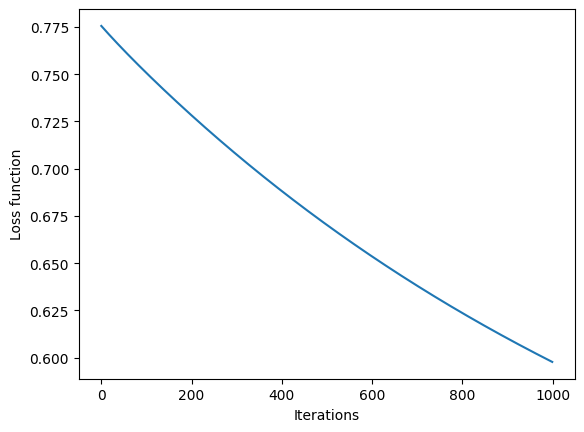

In [13]:
# PLotting the loss values for every training iterations

loss_plot = [loss_hist[i] for i in range(len(loss_hist))]
plt.xlabel("Iterations")
plt.ylabel("Loss function")
plt.plot(loss_plot)
plt.show()

### 2.7 Experimenting with different values of the Hyperparemeters

Previously we have chosen learning rate as 0.01. Now you have to train the model with learning rate as 0.01, 0.001 and 0.009 and compare the performance.

Training with learning rate: 0.001
Loss:  [1.10363479]
Loss:  [1.03616312]
Loss:  [0.97576372]
Loss:  [0.92235368]
Loss:  [0.8756764]
Loss:  [0.83532676]
Loss:  [0.80078785]
Loss:  [0.77147278]
Loss:  [0.74676511]
Loss:  [0.72605342]
Train Accuracy for learning rate 0.001: 47.46666666666667
Test Accuracy for learning rate 0.001: 49.2


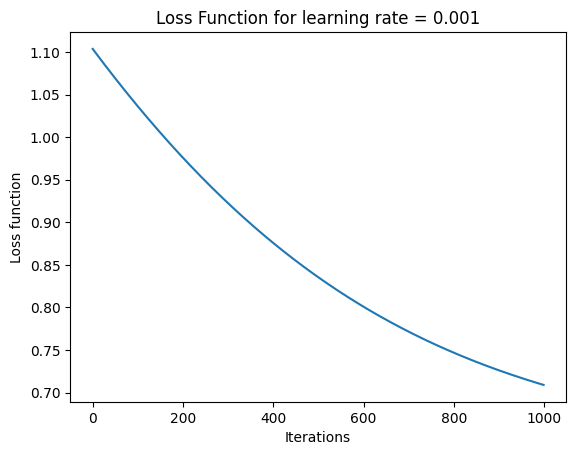

Training with learning rate: 0.009
Loss:  [1.09796545]
Loss:  [0.7240686]
Loss:  [0.64117785]
Loss:  [0.6189705]
Loss:  [0.60592274]
Loss:  [0.59468802]
Loss:  [0.58425046]
Loss:  [0.57443555]
Loss:  [0.56518302]
Loss:  [0.55645059]
Train Accuracy for learning rate 0.009: 82.33333333333334
Test Accuracy for learning rate 0.009: 82.6


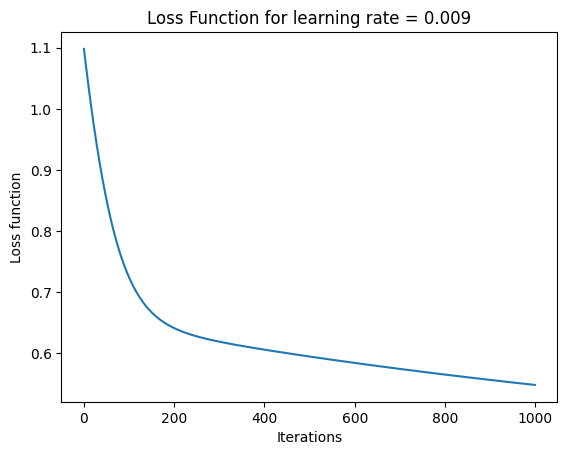

In [14]:
## CODE REQUIRED ##

"""
Manually choose the hyperparameter (learning rate) and train the model.
Then compare the performance with different value of hyperparameter.
"""

### START CODE HERE ###
# prompt: Previously we have chosen learning rate as 0.01. Now you have to train the model with learning rate as 0.01, 0.001 and 0.009 and compare the performance.

initial_w, initial_b, alpha = initialize_parameters()
num_iterations = 1000

learning_rates = [0.001, 0.009]
for alpha in learning_rates:
    print(f"Training with learning rate: {alpha}")
    w, b, loss_hist = batch_gradient_descent_logistic_regression(X_train, y_train, initial_w, initial_b, alpha, num_iterations)
    p_train = predict(X_train, w,b)
    train_accuracy = np.mean(p_train == y_train) * 100
    print(f'Train Accuracy for learning rate {alpha}: {train_accuracy}')
    p_test = predict(X_test, w,b)
    test_accuracy = np.mean(p_test == y_test) * 100
    print(f'Test Accuracy for learning rate {alpha}: {test_accuracy}')
    loss_plot = [loss_hist[i] for i in range(len(loss_hist))]
    plt.xlabel("Iterations")
    plt.ylabel("Loss function")
    plt.title(f"Loss Function for learning rate = {alpha}")
    plt.plot(loss_plot)
    plt.show()
### END CODE HERE ###

## Task: Submitting Your Predictions

After training your Logistic Regression model on the provided training dataset, you have generate predictions for the test dataset named `pumpkin_test_features.csv`, your final task is to save the predicted labels for the test dataset in a file named `RollNo_Logistic.csv`.

### Instructions for Submission:
1. **Format**:  
   The `RollNo_Logistic.csv` file should contain one label per line, corresponding to the order of the test dataset features provided to you.Ensure there are no extra spaces, commas, or blank lines.

2. **File Name**:  
The file must be named `RollNo_Logistic.csv` exactly (case-sensitive).



In [15]:
"""
Write the code to save the predictions in required format
"""
### START CODE HERE ###
# Load the test data
X_test_new = pd.read_csv('content/pumpkin_test_features.csv')  # Use header=None if no headers in the file
X_test_new = X_test_new.values
# Scale the test data using the same scaler used for the training data
X_test_new = min_max_scaler(X_test_new)

# Predict the labels for the test data
predictions = predict(X_test_new, w, b)

# Save the predictions to a CSV file
output_file = '22CS30056_Logistic.csv'
np.savetxt(output_file, predictions, fmt='%d')

print(f"Predictions saved successfully to {output_file}")

Predictions saved successfully to 22CS30056_Logistic.csv


## Part 2: Support Vector Machine
Just like implementing logistic regression now you have to implement SVM for the dataset

**Note**: For SVM use of sklearn library is allowed

In [16]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

### 2.1. Reading the data

In the function ```load_data```, you have to read data from the file, store it in a dataframe and split the data from the dataframe into two numpy arrays X and y.

**X** : data of the input features

**y**  : data of the class labels

The class labels in **y** should be replaced with '0'(Çerçevelik) and '1'(Ürgüp Sivrisi), for corresponding classes.

In [17]:
## CODE REQUIRED ##

def load_data(filepath):
    """
    This function loads the data into a pandas dataframe and converts it into X and y numpy arrays
    y should be a binary numpy array with values 0 and 1, for 2 different classes
    Args:
        filepath: File path as a string
    Returns:
        X: Input data of the shape (# of samples, # of input features)
        y: Target variable of the shape (# of sample,) with values 0 and 1, for 2 different classes
    """

    ### START CODE HERE ###
    X=pd.read_csv(filepath)
    y=X['Class']
    X=X.drop(columns=['Class'])
    X=X.to_numpy()
    y=y.to_numpy()
    y = np.where(y == 'Çerçevelik', 0, 1)


    ### END CODE HERE ###

    return X,y

filepath = None
### START CODE HERE ###
## set the file path
filepath='content/Pumpkin_Dataset.csv'
### END CODE HERE ###

X, y = load_data(filepath)

print("Shape of X: ",X.shape, "Shape of y: ",y.shape)

Shape of X:  (2000, 12) Shape of y:  (2000,)


We need to pre-process the data. We are using min-max scaler to scale the input data ($X$).

After that, we split the data (```X``` and ```y```) into a training dataset (```X_train``` and ```y_train```) and test dataset (```X_test``` and ```y_test```)

In [18]:
## Data scaling and train-test split

def train_test_split(X, y, test_size=0.25, random_state=None):
    if random_state is not None:
        np.random.seed(random_state)
    indices = np.arange(X.shape[0])
    np.random.shuffle(indices)

    split_index = int(X.shape[0] * (1 - test_size))

    train_indices = indices[:split_index]
    test_indices = indices[split_index:]

    X_train = X[train_indices]
    X_test = X[test_indices]
    y_train = y[train_indices]
    y_test = y[test_indices]

    return X_train, X_test, y_train, y_test

def min_max_scaler(X, feature_range=(0, 1)):
    X_min = np.min(X, axis=0)
    X_max = np.max(X, axis=0)

    X_scaled = (X-X_min)/(X_max-X_min)

    return X_scaled

# Feature normalization
X = min_max_scaler(X)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)
print("Shape of X_train: ",X_train.shape, "Shape of y_train: ",y_train.shape)
print("Shape of X_test: ",X_test.shape, "Shape of y_test: ",y_test.shape)

Shape of X_train:  (1500, 12) Shape of y_train:  (1500,)
Shape of X_test:  (500, 12) Shape of y_test:  (500,)


### 2.2. Initializing SVM and training the model
Initialize the SVM classifier using the `SVC` class from `sklearn`. You can experiment with different kernel types such as `linear`, `poly`, `rbf`, etc.

Fit the SVM model using the training dataset (`X_train`, `y_train`) to learn from the data.

In [19]:
# Initialize the SVM classifier
# Initialize the SVM classifier
svm_classifier = SVC(kernel='linear') # You can change the kernel type here (e.g., 'poly', 'rbf')

# Fit the SVM model
svm_classifier.fit(X_train, y_train)

# Train the model


SVC(kernel='linear')

### 2.3. Evaluate the model on both training and testing data
Evaluate your model and interpret your results based on the performance

Compare `SVM` Model with `Logistic Regression`, which one performed better, state the possible reason

In [20]:
"""
Compute the accuracy of SVM model both test and training dataset.
You can use library functions
"""

### START CODE HERE ###
# Predict on the training and testing sets
y_pred_train = svm_classifier.predict(X_train)
y_pred_test = svm_classifier.predict(X_test)

# Calculate the accuracy scores
train_accuracy_svm = accuracy_score(y_train, y_pred_train)
test_accuracy_svm = accuracy_score(y_test, y_pred_test)

print(f"SVM Train Accuracy: {train_accuracy_svm}")
print(f"SVM Test Accuracy: {test_accuracy_svm}")

# Compare with Logistic Regression results
# Assuming you have the following variables from the Logistic Regression part:
# train_accuracy, test_accuracy

print(f"Logistic Regression Train Accuracy: {np.mean(p_train == y_train) * 100}")
print(f"Logistic Regression Test Accuracy: {np.mean(p_test == y_test) * 100}")

# Compare performance
if test_accuracy_svm > np.mean(p_test == y_test):
    print("SVM performed better than Logistic Regression.")
    print("Possible reasons could include:")
    print("- The data might be linearly separable or the chosen kernel for SVM is better suited to the data's underlying structure.")
    print("- SVM is less prone to overfitting in certain scenarios, leading to better generalization on unseen data.")
elif test_accuracy_svm < np.mean(p_test == y_test):
    print("Logistic Regression performed better than SVM.")
    print("Possible reasons could include:")
    print("- The data might be better modeled by a linear decision boundary.")
    print("- The chosen SVM kernel might not be ideal, or the hyperparameters of the SVM model need tuning.")
    print("- Logistic Regression might have lower variance compared to SVM with the current parameters.")
else:
    print("Both models performed equally on the test set.")
### END CODE HERE ###

SVM Train Accuracy: 0.8853333333333333
SVM Test Accuracy: 0.87
Logistic Regression Train Accuracy: 82.33333333333334
Logistic Regression Test Accuracy: 82.6
SVM performed better than Logistic Regression.
Possible reasons could include:
- The data might be linearly separable or the chosen kernel for SVM is better suited to the data's underlying structure.
- SVM is less prone to overfitting in certain scenarios, leading to better generalization on unseen data.


## Task: Submitting Your Predictions

After training your Logistic Regression model on the provided training dataset, you have generate predictions for the test dataset, your final task is to save the predicted labels for the test dataset in a file named `RollNo_SVM.csv`.

### Instructions for Submission:
1. **Format**:  
   The `RollNo_SVM.csv` file should contain one label per line, corresponding to the order of the test dataset features provided to you.Ensure there are no extra spaces, commas, or blank lines.

2. **File Name**:  
The file must be named `RollNo_SVM.csv` exactly (case-sensitive).



In [21]:
# Load the test data
X_test_new = pd.read_csv('content/pumpkin_test_features.csv')  # Use header=None if no headers in the file
X_test_new = X_test_new.values
# Scale the test data using the same scaler used for the training data
X_test_new = min_max_scaler(X_test_new)

# Predict the labels for the test data using the trained SVM model
svm_predictions = svm_classifier.predict(X_test_new)

# Save the predictions to a CSV file
output_file = '22CS30056_SVM.csv'
np.savetxt(output_file, svm_predictions, fmt='%d')

print(f"Predictions saved successfully to {output_file}")

Predictions saved successfully to 22CS30056_SVM.csv
